In [1]:
#
#
#   Speaker Identification.
#   Data comes from http://www.openslr.org/12/
#   Task: Given 't' seconds of speech, identify the speaker.
#   10-class classification: 5 male and 5 female speakers.
#   Training on about 10 minutes of speech per speaker.
#
#
import soundfile as sf            # To read .flac files.   
import speech_recognition as sr   # pip install SpeechRecognition.

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sq = lambda x: x*x

durationCheck = 10.      # Only consider files with 10 or more seconds of audio.
deltaT        = 0.2      # Audio frame size is 0.2 seconds.
noisy         = 0.1      # This sets the limit for static, i.e. pauses in speech.
lim1 = 10; lim2 = 410    # Lower and upper frequencies. 
                         # For the above parameters and 16 kHz sampling, this range is about 50 - 2000 Hz.  
audioType  = ".flac"               # Flac files. 
path       = "LibriSpeech/"        # Path where audio files are located.
trainSet   = "train-clean/"        # Training set.
cvSet      = "cv-clean/"           # Cross-Validation set.
tstSet     = "test-clean/"         # Test set. 
maxminFile = "min_max_values.dat"  # File to store max and min values for each frequency bin.
outfolder  = "networks/"           # Folder to store trained networks.
stem       = "nn"                  # Output network filename stem.    

# These are the speakers.
# Female: 19, 32, 39, 40, 83
# Male: 26, 27, 78, 405, 196
speakers = ["19/",
            "26/",
            "32/",
            "27/",
            "39/",
            "78/",
            "40/",
            "405/", 
            "83/",
            "196/"]

numFeatures = lim2-lim1
numSpeakers = len(speakers)

In [2]:
# Read data from a folder into a list.
def getData(division,speaker):
  fname = path+division+speaker  
  subPaths = [v+"/" for v in os.listdir(fname) if v[0] != "."]
  dataFiles = []
  for subPath in subPaths:
    files = [v for v in os.listdir(fname+subPath) if v[0] != "." and audioType in v]
    for fil in files:
      data,samplerate = sf.read(fname+subPath+fil)  
      duration = len(data)*1./samplerate
      if duration >= durationCheck: dataFiles.append(fname+subPath+fil)
        
  chunksF = []

  for fil in dataFiles:
    data,samplerate = sf.read(fil)  
    duration = len(data)*1./samplerate

    # Divide audio data into frames, or chunks. 
    numChunks = int(duration/deltaT)
    sizeChunk = int(len(data)/numChunks)
    for lp in range(0,numChunks):    
      chunk = data[lp*sizeChunk:(lp+1)*sizeChunk]      # get a chunk of speech.     
      chunksF.append(np.abs(np.fft.rfft(chunk))[lim1:lim2])  # take the FFT.

    # Delete quiet parts of speech, i.e. pauses.
    # Most of the power is in the bottom 50% of frequencies.
    mu = np.mean([np.mean(chunksF[i][:numFeatures//2]) for i in range(0,len(chunksF))])
    dataF = []
    for chunkF in chunksF:
      if np.mean(chunkF[:numFeatures//2]) > noisy*mu:
        dataF.append(chunkF)
    
  return dataF

# Return data for all speakers.
def getDataSpeakers(division):
  dataSpeakers = []
  for speaker in speakers:
    print("Getting data for speaker: "+speaker)
    dataSpeakers.append(getData(division,speaker))

  N = np.sum([np.shape(s)[0] for s in dataSpeakers])
  tX = np.mat(np.zeros((N,numFeatures)))
  tY = []
  speakerIndices = [0]    # Index corresponding to start of speaker 'n'
  
  ctr = 0; lp = 0
  for dataSpeaker in dataSpeakers:
    for j in range(0,len(dataSpeaker)):
      for k in range(0,numFeatures):
        tX[ctr,k] = dataSpeaker[j][k]
      tY.append(lp)
      ctr += 1  
    speakerIndices.append(ctr)
    lp += 1  
          
  return tX,tY,speakerIndices

In [3]:
# Get data
# as well as locations where speaker 'i' ends, and speaker 'j' begins.
trnX,trnY,trnIdx = getDataSpeakers(trainSet)  

Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 32/
Getting data for speaker: 27/
Getting data for speaker: 39/
Getting data for speaker: 78/
Getting data for speaker: 40/
Getting data for speaker: 405/
Getting data for speaker: 83/
Getting data for speaker: 196/


In [4]:
print(np.shape(trnX), np.shape(trnY))
trnRows = np.shape(trnX)[0]
print(trnIdx)   # Start location of speaker 'i'.

(35396, 400) (35396,)
[0, 3828, 7509, 10908, 13095, 17188, 20396, 24412, 28148, 31672, 35396]


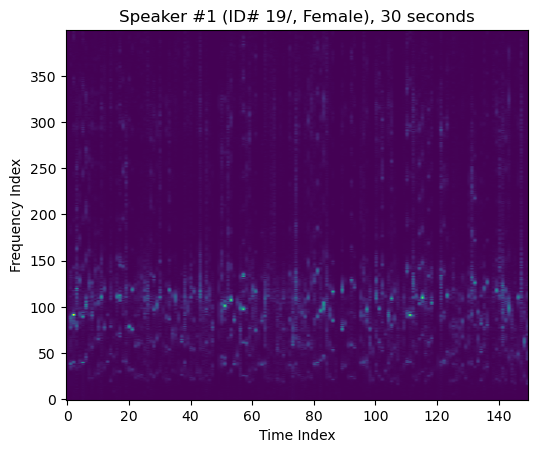

In [5]:
# Make some plots.
# Frequency index from 0...400 represent a range from 50 - 2000 Hz.
# Time index from 0 to 150 represent a range from 0 - 30 seconds.
plt.title("Speaker #1 (ID# 19/, Female), 30 seconds")
plt.xlabel("Time Index")
plt.ylabel("Frequency Index")
plt.imshow(trnX[trnIdx[0]:trnIdx[0]+150,:].T,origin="lower",aspect=0.3)

In [6]:
# Find min and max values for each frequency bin using Training data only.
# Normalize data to lie in the range (0,1).
minArray = []; maxArray = []
for i in range(0,numFeatures):
  minArray.append(np.min(trnX[:,i]))
  maxArray.append(np.max(trnX[:,i]))    

f = open(maxminFile, "w")
for i in range(0,numFeatures):
  f.write(str(maxArray[i]) + " " + str(minArray[i]) + "\n")
f.close()      

for i in range(0,trnRows):
  for j in range(0,numFeatures):
    trnX[i,j] = (trnX[i,j]-minArray[j])/(maxArray[j]-minArray[j])  

In [27]:
# 
# This is the architecture of the network.
# Hyper-parameters to be fixed through cross-validation are:
#                         (i)   How many layers are necessary?
#                         (ii)  How many nodes per layer?
#                         (iii) What kind of activation function to use?
# 
import torch.nn as nn
class NeuralNetwork(nn.Module):
    def __init__(self, out_dim):
        super(NeuralNetwork, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(400, out_dim),
            nn.Tanh(),
            nn.Linear(out_dim, out_dim),
            nn.Tanh(),
            nn.Linear(out_dim, out_dim),
            nn.Tanh(),
            nn.Linear(out_dim, out_dim),
            nn.Tanh(),
            nn.Linear(out_dim, out_dim),
            nn.Tanh(),
            nn.Linear(out_dim, out_dim),
            nn.Softmax()
        )
        self.training_loss_list = []
        self.testing_acc_list = []
        self.best_testing_acc = 0

    def forward(self, x):
        logits = self.linear_tanh_stack(x)
        return logits

In [28]:
'''train neural network'''
import math 
import torch
import torch.nn.functional as F

batch_size = 128
epoch_num=200
lr = 1e-3              # learning rate
weight_decay = 1e-5   # weight decay
log_interval = 100 
name = 'softm'
out_dim = 10

def train(train_loader, test_loader):
    # Model and Optimizer
    tree = NeuralNetwork(out_dim)

    optimizer = torch.optim.Adam(tree.parameters(),
                                 lr = lr,
                                 weight_decay = weight_decay)

    # Utils
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cpu")

    for epoch in range(epoch_num):

        # Training
        tree.train()
        for batch_idx, (data, label) in enumerate(train_loader):

            batch_size = data.size()[0]
            data, label = data.to(device), label.to(device)

            output = tree.forward(data) # data[128,1,28,28]

            loss = criterion(output, label.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print training status
            if batch_idx % log_interval == 0:
                pred = output.data.max(1)[1]
                correct = pred.eq(label.view(-1).data).sum()

                msg = (
                    "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f} |"
                    " Correct: {:03d}/{:03d}"
                )
                print(msg.format(epoch, batch_idx, loss, correct, batch_size))
                tree.training_loss_list.append(loss.cpu().data.numpy())

        # Evaluating
        tree.eval()
        correct = 0.

        for batch_idx, (data, label) in enumerate(test_loader):

            batch_size = data.size()[0]
            data, label = data.to(device), label.to(device)

            output = tree.forward(data)

            pred = output.data.max(1)[1]
            correct += pred.eq(label.view(-1).data).sum()

        accuracy = 100.0 * float(correct) / len(test_loader.dataset)

        tree.testing_acc_list.append(accuracy)

        if accuracy > tree.best_testing_acc:
            tree.best_testing_acc = accuracy
            torch.save(tree, f'model/{name}.pt')

        msg = (
            "\nEpoch: {:02f} | Testing Accuracy: {}/{} ({:.3f}%) | "
            " Historical Best: {:.3f}%\n"
        )

        print(
            msg.format(
                epoch, correct, len(test_loader.dataset), accuracy,
                tree.best_testing_acc
            )
        )

    best_model = torch.load(f'model/{name}.pt')
    best_model.testing_acc_list = tree.testing_acc_list
    torch.save(best_model, f'model/{name}.pt')
    return max(tree.testing_acc_list)

def matrix_to_dataloader(dataX, dataY):
    dataX = torch.from_numpy(np.asarray(dataX)).float()
    dataY = torch.from_numpy(np.asarray(dataY)).long()
    data_set = torch.utils.data.TensorDataset(dataX, dataY)
    
    train_size = math.floor(np.shape(trnY)[0]*0.8)
    test_size = np.shape(trnY)[0] - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data_set, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size,
        shuffle=True,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = batch_size,
        shuffle=True,
    )

    return train_loader, test_loader


In [29]:
train_loader, test_loader = matrix_to_dataloader(trnX, trnY)
acc = train(train_loader, test_loader)

D:\Anaconda3\envs\python38\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 00 | Batch: 000 | Loss: 2.30385 | Correct: 011/128
Epoch: 00 | Batch: 100 | Loss: 2.28066 | Correct: 027/128
Epoch: 00 | Batch: 200 | Loss: 2.22930 | Correct: 028/128

Epoch: 0.000000 | Testing Accuracy: 1497.0/7080 (21.144%) |  Historical Best: 21.144%

Epoch: 01 | Batch: 000 | Loss: 2.17726 | Correct: 032/128
Epoch: 01 | Batch: 100 | Loss: 2.26549 | Correct: 022/128
Epoch: 01 | Batch: 200 | Loss: 2.17157 | Correct: 036/128

Epoch: 1.000000 | Testing Accuracy: 2090.0/7080 (29.520%) |  Historical Best: 29.520%

Epoch: 02 | Batch: 000 | Loss: 2.15844 | Correct: 038/128
Epoch: 02 | Batch: 100 | Loss: 2.09414 | Correct: 048/128
Epoch: 02 | Batch: 200 | Loss: 2.09361 | Correct: 045/128

Epoch: 2.000000 | Testing Accuracy: 2666.0/7080 (37.655%) |  Historical Best: 37.655%

Epoch: 03 | Batch: 000 | Loss: 2.10427 | Correct: 047/128
Epoch: 03 | Batch: 100 | Loss: 2.04569 | Correct: 059/128
Epoch: 03 | Batch: 200 | Loss: 2.07559 | Correct: 048/128

Epoch: 3.000000 | Testing Accuracy: 272

KeyboardInterrupt: 

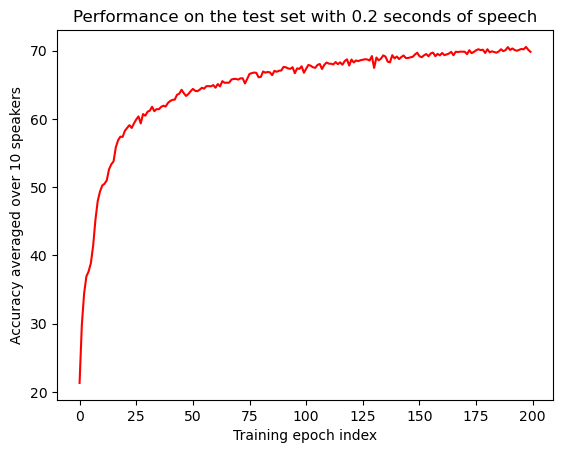

In [12]:
import matplotlib.pyplot as plt
tree = torch.load('model/temp.pt')
y = tree.testing_acc_list
x = [i for i in range(len(y))]
l1=plt.plot(x,y,'r-',label='type1')
plt.xlabel("Training epoch index")
plt.ylabel("Accuracy averaged over 10 speakers")
plt.title("Performance on the test set with 0.2 seconds of speech")
plt.show()

In [13]:
#
# Data for cross-validation and testing.
# We use the cross validation data set to determine the network architecture,
# i.e. depth and width of the network, type of activation function, etc.
#
cvX,cvY,cvIdx = getDataSpeakers(cvSet)  
tstX,tstY,tstIdx = getDataSpeakers(tstSet)  
cvRows = np.shape(cvX)[0]; tstRows = np.shape(tstX)[0]

f = open(maxminFile)    # Read the max and min values obtained from the training set.
maxi = []; mini = []
for lp in range(0,numFeatures):
  line = f.readline().split()
  maxi.append(float(line[0]))
  mini.append(float(line[1]))
f.close()

# Normalize to put data in the range (0,1).
for i in range(0,cvRows):
  for j in range(0,numFeatures):
    cvX[i,j] = (cvX[i,j]-mini[j])/(maxi[j]-mini[j])  

for i in range(0,tstRows):
  for j in range(0,numFeatures):
    tstX[i,j] = (tstX[i,j]-mini[j])/(maxi[j]-mini[j])  

Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 32/
Getting data for speaker: 27/
Getting data for speaker: 39/
Getting data for speaker: 78/
Getting data for speaker: 40/
Getting data for speaker: 405/
Getting data for speaker: 83/
Getting data for speaker: 196/
Getting data for speaker: 19/
Getting data for speaker: 26/
Getting data for speaker: 32/
Getting data for speaker: 27/
Getting data for speaker: 39/
Getting data for speaker: 78/
Getting data for speaker: 40/
Getting data for speaker: 405/
Getting data for speaker: 83/
Getting data for speaker: 196/


In [14]:
#
# Test the classifier.
# nns is a list of trained networks. It is sometimes helpful to pass more than one network,
# since errors made by different networks may cancel out.
# tX: Data to test
# tY: Target, i.e. speaker ID.
# idx: List of indices indicating the starting location of a speaker.
# skip: Number of increments of 'deltaT' to group together. For e.g. if 'deltaT' = 0.2:
#       If skip = 1, a prediction is made for every 0.2 seconds.
#       If skip = 5, a prediction is made for every 1.0 second.
#
def tstClassifier(nns,tX,tY,idx,skip):

  def maxIdx(A):
    # Pick the prediction with the highest occurance.
    ctr = {}
    for pre in A:
      if pre not in ctr: ctr[pre] = 1
      else: ctr[pre] += 1
      
    rev = {}
    for key in ctr.keys():
      rev[ctr[key]] = key
    return rev[np.max(list(rev.keys()))]

  # Confusion matrix: Speaker 'm' predicted as speaker 'n'.
  confusion = np.mat(np.zeros((numSpeakers,numSpeakers)))  
  
  correct = 0; al = 0
  for cvi in range(0,numSpeakers):
    # idx contain the start location of each speaker.
    for lpx in range(idx[cvi],idx[cvi+1]-skip,skip):
      bestArray = []

      # Consider "skip" number of data points together.
      for lp in range(lpx,lpx+skip):      
        A = torch.Tensor([tX[lp,i] for i in range(0,numFeatures)])
        prediction = []       
 
        # Average over multiple trained networks.        
        for nn in nns:  
          pred = nn.forward(A)
          ctr = {}
          for i in range(0,numSpeakers):
            ctr[pred[i].item()] = i
          prediction.append(ctr[np.max(list(ctr.keys()))])
        bestArray.append(maxIdx(prediction))

      best = maxIdx(bestArray)                
      if best == tY[lpx]: correct += 1

      # Populate the confusion matrix.  
      for i in range(0,numSpeakers):
        if best == i: confusion[cvi,i] += 1
      al += 1

  return correct*1./al, confusion

In [20]:
tree = torch.load('model/temp.pt')
maxT = 15
for st in range(50,int(maxT/deltaT)+1, 5):
  A,c = tstClassifier([tree],tstX,tstY,tstIdx,st)
  print(round(st*deltaT,2),np.mean(A))

10.0 0.9735449735449735
11.0 0.9764705882352941
12.0 0.9743589743589743
13.0 0.9793103448275862
14.0 0.9851851851851852
15.0 0.984
